# Check knockoff exchangeability


Given $\Sigma$ from Pan-UKBB and the $S$ based on ME solvers, we will see if knockoffs satisfy exchangeability in 2 ways:
1. Sample $X$ and $\tilde{X}$, and compare empirical correlation
2. Compare $\Sigma$ with $\Sigma - S$ directly

In [15]:
using Plots
using JLD2
using Distributions
using LinearAlgebra
using LaTeXStrings
using ProgressMeter
using Knockoffs
gr(fmt=:png)

function solve_for_S(Sigma::AbstractMatrix, groups, rep_threshold)
    if 0 < rep_threshold < 1
        # representative approach
        group_reps = choose_group_reps(Symmetric(Sigma), groups, threshold=rep_threshold)
        S11, S, obj = solve_s_graphical_group(Symmetric(Sigma), groups, group_reps, :maxent,
            m=5, verbose=false)
    else
        # regular group knockoff
        S, _, obj = solve_s_group(Symmetric(Sigma), groups, :maxent, m=5, verbose=false)
    end
    return S
end

function compare_corr_of_S_and_ΣminusS(knockoff_dir, region, rep_threshold; npoints=Inf, 
    plt_title="threshold = $rep_threshold", plt_xlabel=L"\Sigma_{ij}", 
    plt_ylabel=L"\Sigma_{ij} - S_{ij}", right_margin=0Plots.mm)
    # read Sigma block and solve knockoff problem
    result = JLD2.load(joinpath(knockoff_dir, region))
    Σ = result["Sigma"]
    groups = hc_partition_groups(Symmetric(Σ), cutoff=0.5, linkage=:average)
    S = solve_for_S(Σ, groups, rep_threshold)
    ΣminusS = Σ - S
    p = size(Σ, 1)

    # check exchangeability across groups
    Σ_r2 = Float64[]
    ΣminusS_r2 = Float64[]
    @showprogress for j in 1:p, i in 1:p
        groups[i] == groups[j] && continue
        @views begin
            push!(Σ_r2, Σ[i, j])
            push!(ΣminusS_r2, ΣminusS[i, j])
        end
    end

    # don't plot too many dots, takes too long
    if length(Σ_r2) > npoints
        idx = sample(1:length(Σ_r2), replace=false, npoints) |> sort
        Σ_r2 = Σ_r2[idx]
        ΣminusS_r2 = ΣminusS_r2[idx]
    end
    # make plot
    plt = scatter(Σ_r2, ΣminusS_r2, 
        ylim = (-1, 1), xlim=(-1, 1), legend=false,
        xlabel=plt_xlabel, ylabel=plt_ylabel, 
        alpha=0.3, markersize=1, title = plt_title,
        right_margin=right_margin, 
        size=(300, 300),
    )
    plot!(plt, [-1, 1], [-1, 1], color=:red, linestyle=:dash)
    
    # annotate right most plot
#     if rep_threshold == 1
#         chr = split(region, '/')[1][4:end]
#         annotate!(plt, 1.3, 0.1, Plots.text("Block from chr $chr", :black, rotation = 270))
#     end
    chr = split(region, '/')[1][4:end]
    if chr == "21"
        annotate!(plt, 1.3, 0.1, Plots.text("threshold $rep_threshold", :black, rotation = 270))
    end

    return plt
end

compare_corr_of_S_and_ΣminusS (generic function with 1 method)

## Checking excheangibility by comparing $\Sigma$ and $\Sigma - S$ directly

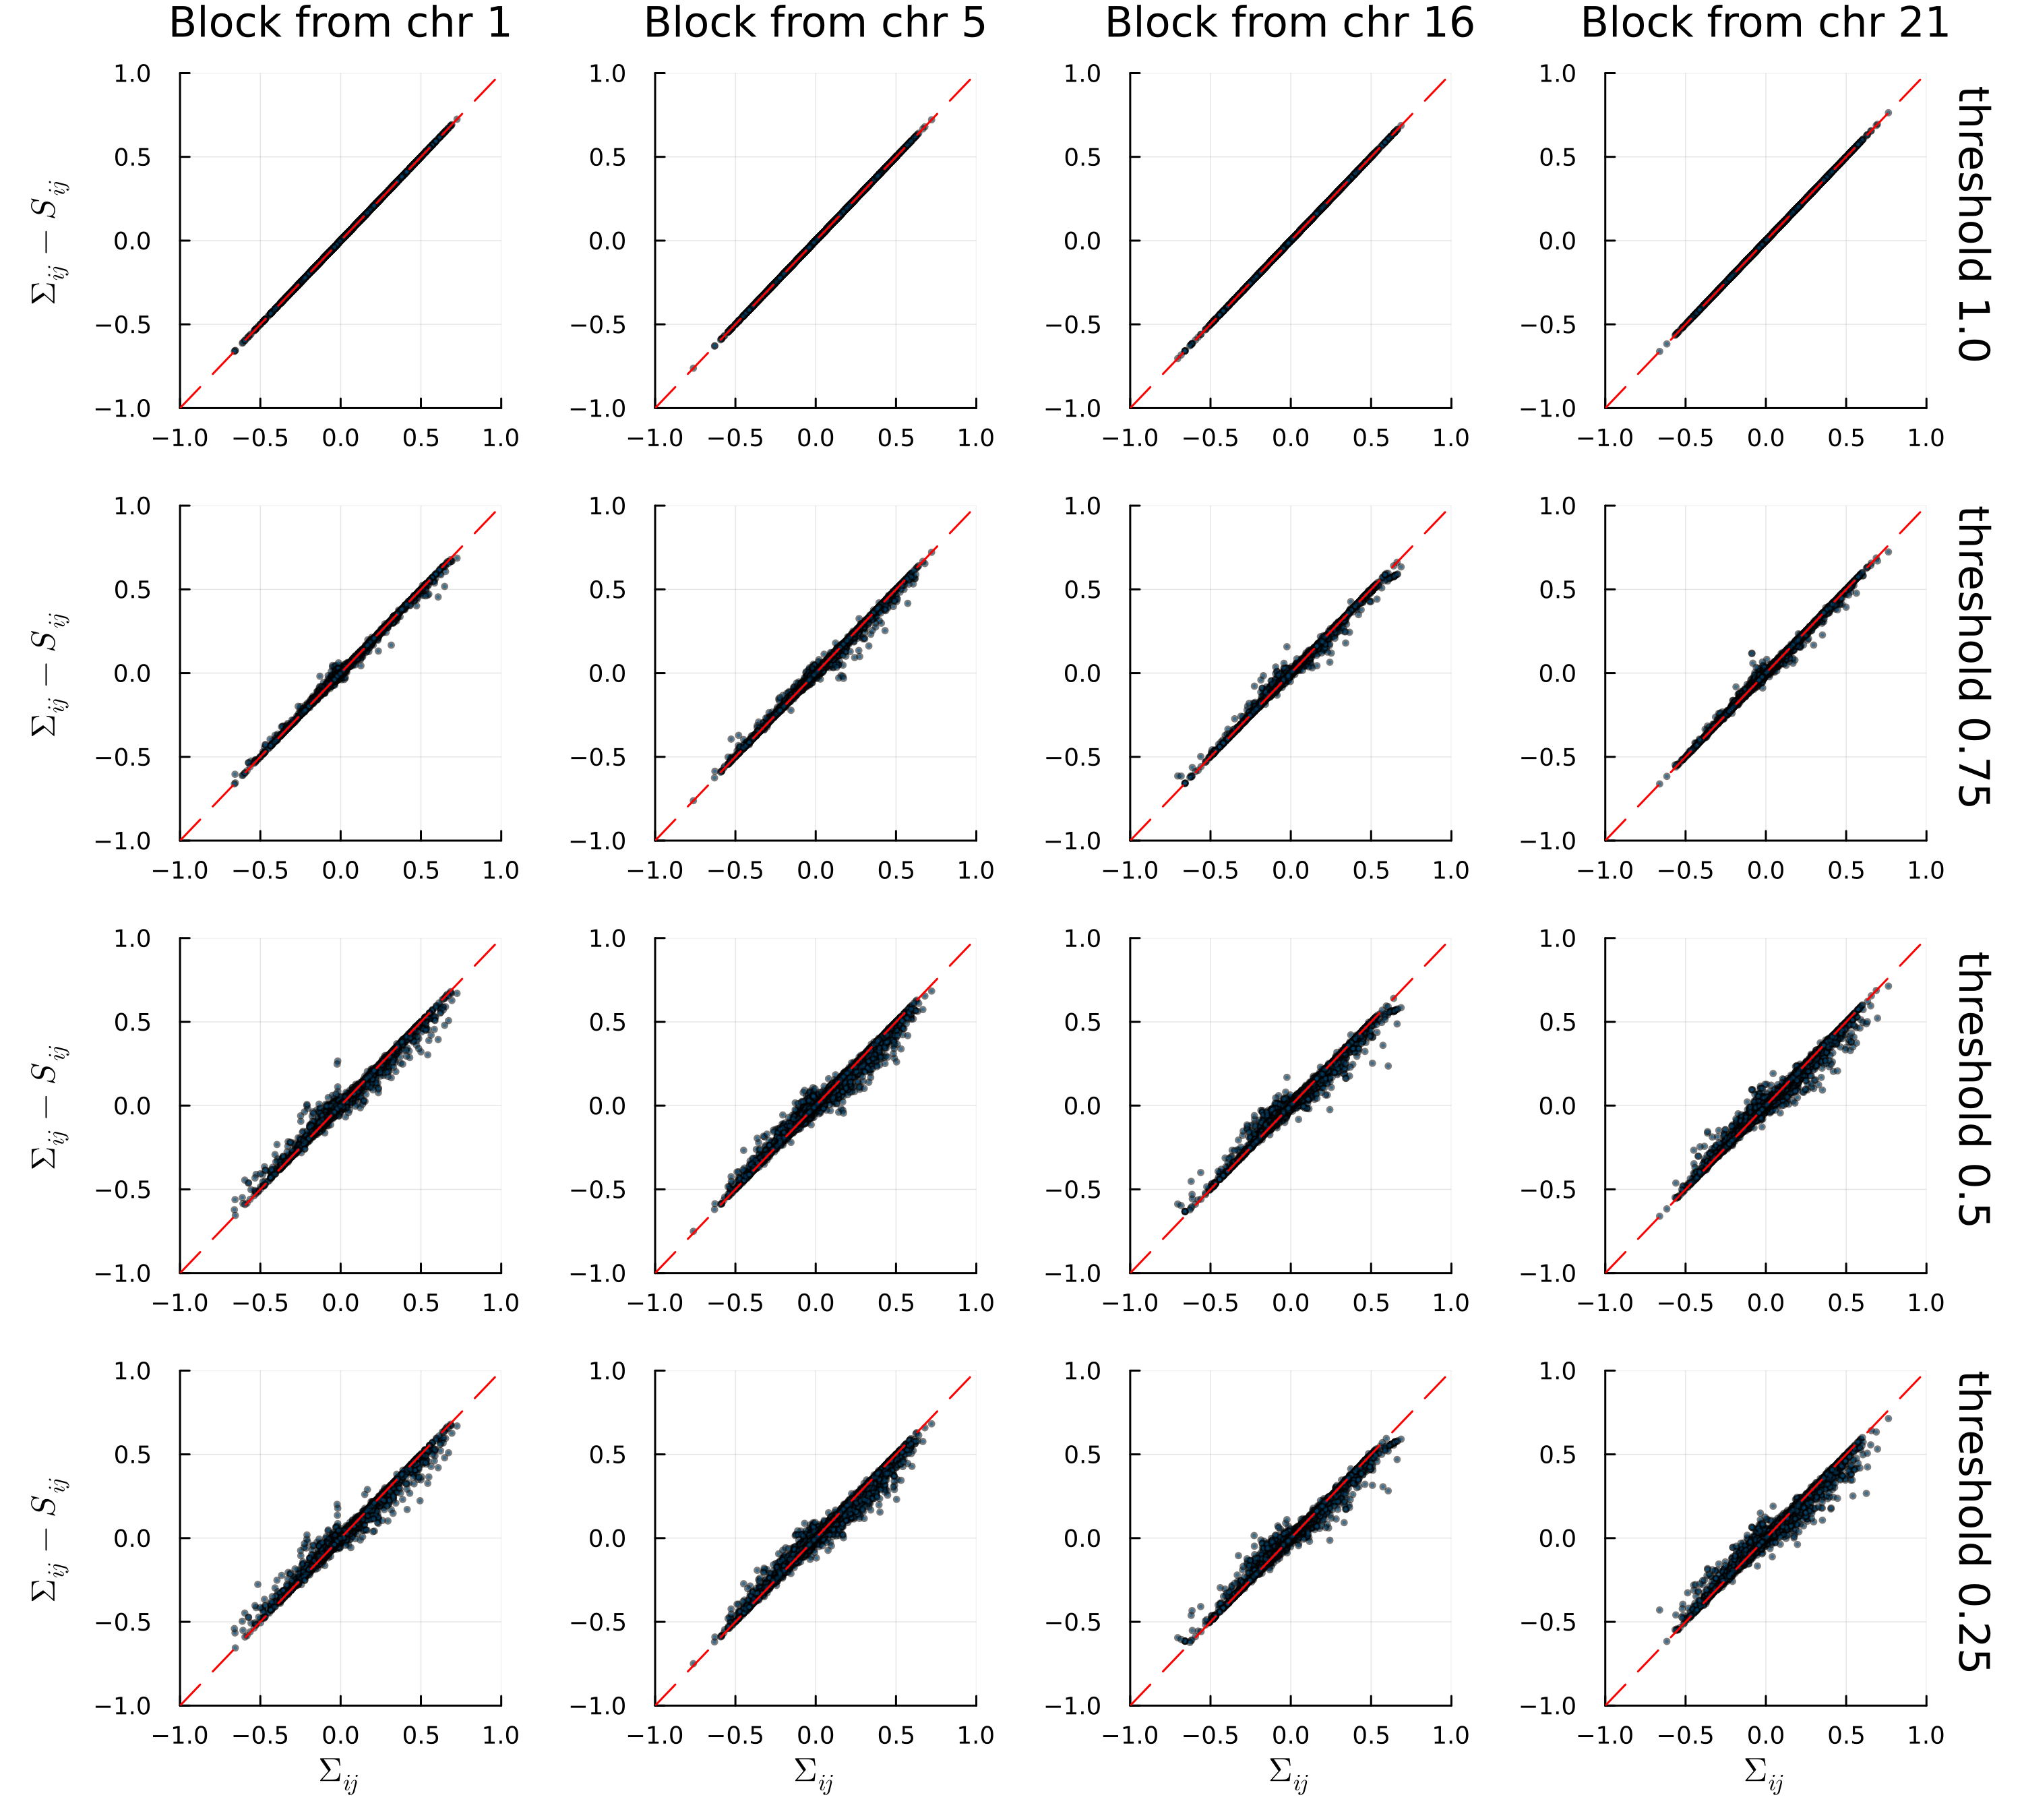

In [20]:
# knockoff directories
knockoff_dir = "/oak/stanford/groups/zihuai/pan_ukb_group_knockoffs/EUR"

# randomly selected regions to check
regions = [
    "chr1/LD_start100826405_end102041015.h5",
    "chr5/LD_start171074292_end172678326.h5",
    "chr16/LD_start52035823_end53382571.h5",
    "chr21/LD_start24696231_end26469121.h5",
]

# compare
plts = []
for rep_threshold in [1.0, 0.75, 0.5, 0.25]
    for (i, region) in enumerate(regions)
        chr = split(region, '/')[1][4:end]
        plt = compare_corr_of_S_and_ΣminusS(knockoff_dir, region, rep_threshold, 
            plt_title = (rep_threshold == 1.0 ? "Block from chr $chr" : ""), 
            plt_ylabel = (chr == "1" ? L"\Sigma_{ij} - S_{ij}" : ""),
            plt_xlabel = (rep_threshold == 0.25 ? L"\Sigma_{ij}" : ""),
            right_margin = (chr == "21" ? 10Plots.mm : 0Plots.mm))
        push!(plts, plt)
    end
end
plt = plot(plts..., size=(1000, 900), left_margin=5Plots.mm, dpi=300)

In [21]:
savefig(plt, "/home/users/bbchu/knockoffs/plots/exchangeability.png")

"/home/users/bbchu/knockoffs/plots/exchangeability.png"

In [24]:
for region in regions
    result = JLD2.load(joinpath(knockoff_dir, region))
    Σ = result["Sigma"]
    groups = hc_partition_groups(Symmetric(Σ), cutoff=0.5, linkage=:average)
    println("region $region: # SNPs = $(length(groups)), # groups = $(length(unique(groups)))")
end

region chr1/LD_start100826405_end102041015.h5: # SNPs = 247, # groups = 122
region chr5/LD_start171074292_end172678326.h5: # SNPs = 511, # groups = 279
region chr16/LD_start52035823_end53382571.h5: # SNPs = 333, # groups = 177
region chr21/LD_start24696231_end26469121.h5: # SNPs = 431, # groups = 234


# OLD PLOTS BELOW

## First check exchangeability by simulating X

In [146]:
# knockoff directories
typed_knockoff_dir = "/oak/stanford/groups/zihuai/pan_ukb_group_knockoffs/maxent_hc"
imputed_knockoff_dir = "/oak/stanford/groups/zihuai/pan_ukb_group_knockoffs/maxent_hc_all"

# randomly selected regions to check
regions = [
    "chr1/LD_start100826405_end102041015.h5",
    "chr5/LD_start171074292_end172678326.h5",
    "chr16/LD_start52035823_end53382571.h5",
    "chr21/LD_start24696231_end26469121.h5",
]

# compare
plts = []
for region in regions
    typed_plot = compare_corr_by_simulating_X(typed_knockoff_dir, region)
    imputed_plot = compare_corr_by_simulating_X(imputed_knockoff_dir, region)
    plt = plot(typed_plot, imputed_plot, 
        size=(800, 300), left_margin=5Plots.mm, bottom_margin=5Plots.mm)
    push!(plts, plt)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:01:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:55
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:03:06


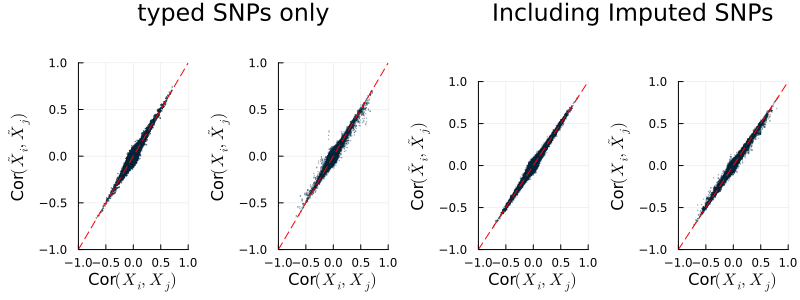

In [147]:
# chr1 region
plts[1]

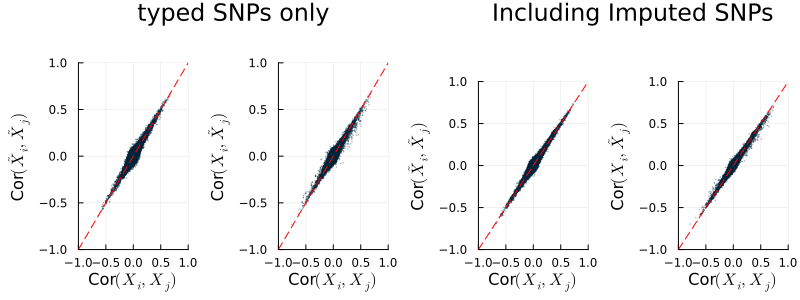

In [148]:
# chr5 region
plts[2]

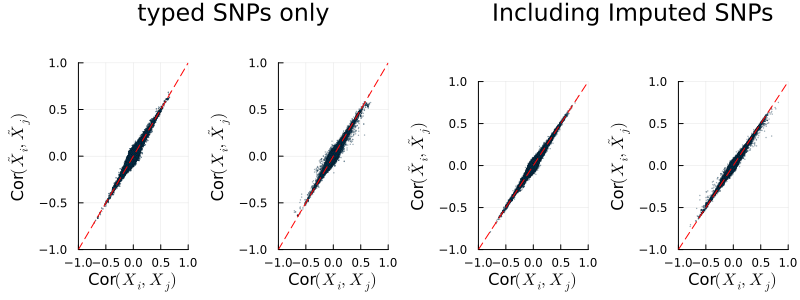

In [149]:
# chr16 region
plts[3]

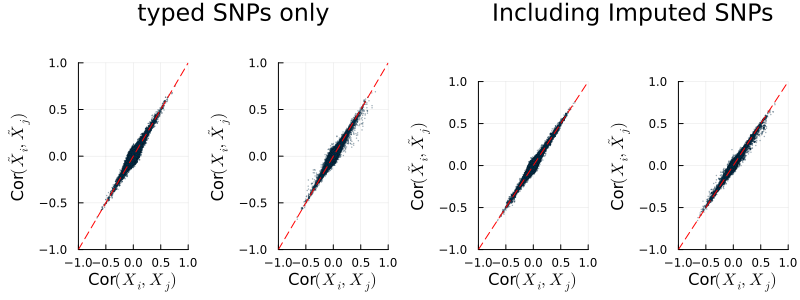

In [150]:
# chr21 region
plts[4]

## Checking excheangibility by comparing $\Sigma$ and $\Sigma - S$ directly

In [10]:
# knockoff directories
typed_knockoff_dir = "/oak/stanford/groups/zihuai/pan_ukb_group_knockoffs/maxent_hc"
imputed_knockoff_dir = "/oak/stanford/groups/zihuai/pan_ukb_group_knockoffs/maxent_hc_all"

# randomly selected regions to check
regions = [
    "chr1/LD_start100826405_end102041015.h5",
    "chr5/LD_start171074292_end172678326.h5",
    "chr16/LD_start52035823_end53382571.h5",
    "chr21/LD_start24696231_end26469121.h5",
]

# compare
plts = []
for region in regions
    typed_plot = compare_corr_of_S_and_ΣminusS(typed_knockoff_dir, region)
    imputed_plot = compare_corr_of_S_and_ΣminusS(imputed_knockoff_dir, region)
    plt = plot(typed_plot, imputed_plot, 
        size=(800, 300), left_margin=5Plots.mm, bottom_margin=5Plots.mm)
    push!(plts, plt)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
Progress: 100%|█████████████████████████████████████████| Time: 0:00:17


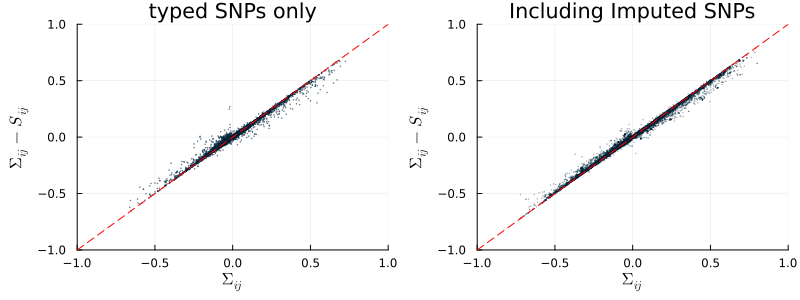

In [11]:
# chr1 region
plts[1]

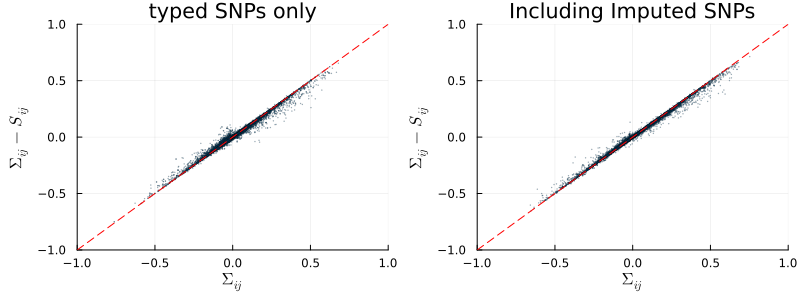

In [12]:
# chr5 region
plts[2]

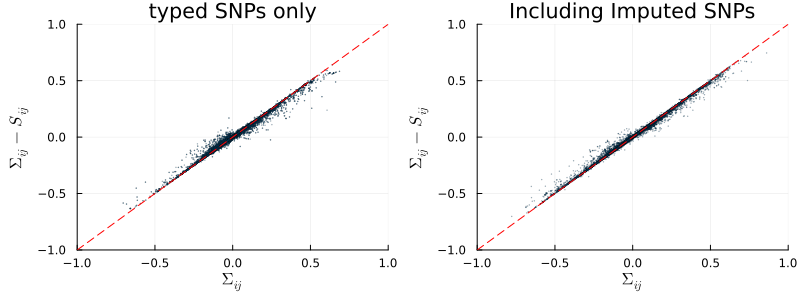

In [13]:
# chr16 region
plts[3]

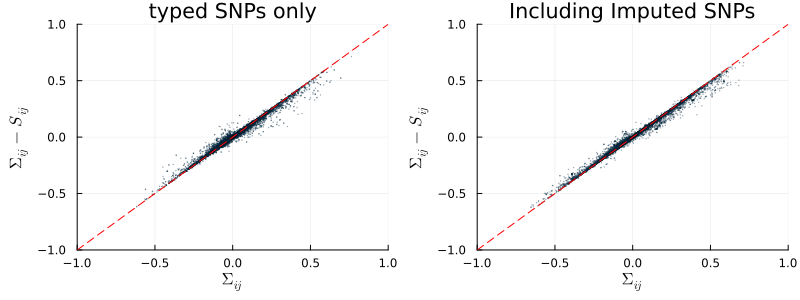

In [14]:
# chr21 region
plts[4]